In [1]:
import pandas as pd
import geopandas as gp
import folium
import numpy as np 
from sklearn.datasets import load_iris
import seaborn as sns

%matplotlib inline

# Pickups and Dropoffs within Community Areas

In [2]:
com_area = gp.read_file('D:/TNC-Demand-Model/Inputs/Chicago Community Areas/geo_export_d8da94d2-4ef1-4ee6-9fff-7bb20d451fe2.shp')

In [3]:
com_area.area_num_1 = com_area.area_num_1.astype(float)

In [4]:
com_area_conflate = pd.read_csv('D:/TNC-Demand-Model/Inputs/Chicago Community Areas/Community_Area_to_Census_Tract.csv')

In [62]:
tods = [1,2,3,4,5]
df3 = pd.DataFrame()
df4 =  pd.DataFrame()
df5 = pd.DataFrame()

In [63]:
for tod in tods:
    print('Working on TOD ' + str(tod))
    df = pd.read_hdf('D:/TNC-Demand-Model/Inputs/Chicago Ride-Hailing/Chicago_TNC_Trips_20.H5', columns = ['Pickup Census Tract','Dropoff Census Tract','MONTH','YEAR','Pickup Community Area','Dropoff Community Area','Trip Seconds','Trip Miles','Fare'],key = 'Weekday_' + str(tod))
    df2 = df[(~np.isnan(df['Dropoff Community Area']))&(~np.isnan(df['Pickup Community Area']))]
    df2 = df2[(np.isnan(df2['Dropoff Census Tract']))|(np.isnan(df2['Pickup Census Tract']))]
    df2['SUPPRESSED_TRIPS'] = 1
   # df2['DAY'] = df2['Trip Start Timestamp'].dt.day
    #df2['MINUTE'] = df2['Trip Start Timestamp'].dt.minute


    df_unsup = df[(~np.isnan(df['Dropoff Community Area']))&(~np.isnan(df['Pickup Community Area']))]
    df_unsup = df_unsup[(~np.isnan(df_unsup['Dropoff Census Tract']))&(~np.isnan(df_unsup['Pickup Census Tract']))]
    df_unsup['UNSUPPRESSED_TRIPS'] = 1
    #df_unsup['DAY'] = df_unsup['Trip Start Timestamp'].dt.day
    #df_unsup['MINUTE'] = df_unsup['Trip Start Timestamp'].dt.minute

    df_external = df[(np.isnan(df['Pickup Community Area']))|(np.isnan(df['Dropoff Community Area']))]
    df_external['EXTERNAL_TRIPS'] = 1

    df3 = df3.append(df2)
    df4 = df4.append(df_unsup)
    df5 = df5.append(df_external)

#sup_pickup_daily = df3.groupby(by = ['MONTH','YEAR','DAY','Pickup Community Area'],as_index = False).sum()
sup_pickup_monthly_sum = df3.groupby(by = ['MONTH','YEAR','Pickup Community Area'],as_index = False).sum()
#sup_pickup_monthly_avg = sup_pickup_daily.groupby(by = ['MONTH','YEAR','Pickup Community Area'],as_index = False).mean()
#sup_dropoff_daily = df3.groupby(by = ['MONTH','YEAR','DAY','Dropoff Community Area'],as_index = False).sum()
sup_dropoff_monthly_sum = df3.groupby(by = ['MONTH','YEAR','Dropoff Community Area'],as_index = False).sum()
#sup_dropoff_monthly_avg = sup_dropoff_daily.groupby(by = ['MONTH','YEAR','Dropoff Community Area'],as_index = False).mean()

Working on TOD 1


C:\Users\transportlab\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Working on TOD 2
Working on TOD 3
Working on TOD 4
Working on TOD 5


In [64]:
unsup_pickup_monthly_sum = df4.groupby(by = ['MONTH','YEAR','Pickup Community Area'],as_index = False).sum()
unsup_dropoff_monthly_sum = df4.groupby(by = ['MONTH','YEAR','Dropoff Community Area'],as_index = False).sum()

df_external_pickup_sum = df5.groupby(by = ['MONTH','YEAR','Pickup Community Area'],as_index = False).sum()
df_external_dropoff_sum = df5.groupby(by = ['MONTH','YEAR','Dropoff Community Area'],as_index = False).sum()


join_pickup = sup_pickup_monthly_sum.merge(unsup_pickup_monthly_sum, on = ['MONTH','YEAR','Pickup Community Area'])
join_pickup = join_pickup.merge(df_external_pickup_sum, on = ['MONTH','YEAR','Pickup Community Area'])

join_dropoff = sup_dropoff_monthly_sum.merge(unsup_dropoff_monthly_sum, on = ['MONTH','YEAR','Dropoff Community Area'])
join_dropoff = join_dropoff.merge(df_external_dropoff_sum, on = ['MONTH','YEAR','Dropoff Community Area'])

join_pickup['Share of Trips Suppressed'] = join_pickup['SUPPRESSED_TRIPS']/(join_pickup['UNSUPPRESSED_TRIPS'] + join_pickup['SUPPRESSED_TRIPS'] + join_pickup['EXTERNAL_TRIPS'])
join_dropoff['Share of Trips Suppressed'] = join_dropoff['SUPPRESSED_TRIPS']/(join_dropoff['UNSUPPRESSED_TRIPS'] + join_dropoff['SUPPRESSED_TRIPS'] + join_dropoff['EXTERNAL_TRIPS'])

join_pickup['Share of Trips External'] = join_pickup['EXTERNAL_TRIPS']/(join_pickup['UNSUPPRESSED_TRIPS'] + join_pickup['EXTERNAL_TRIPS'] + join_pickup['SUPPRESSED_TRIPS'])
join_dropoff['Share of Trips External'] = join_dropoff['EXTERNAL_TRIPS']/(join_dropoff['UNSUPPRESSED_TRIPS'] + join_dropoff['EXTERNAL_TRIPS'] + join_dropoff['SUPPRESSED_TRIPS'])


In [61]:
df5

,Pickup Census Tract,Dropoff Census Tract,MONTH,YEAR,Pickup Community Area,Dropoff Community Area,Trip Seconds,Trip Miles,Fare,UNSUPPRESSED_TRIPS,EXTERNAL_TRIPS,TRAVEL_TIME,SPEED,Trip Category
0,1.703198e+10,1.703106e+10,10,2019,76.0,6.0,1236.0,16.5,20.0,1.0,NaN,20.600000,48.058252,External
7,1.703108e+10,1.703108e+10,2,2020,8.0,8.0,254.0,0.8,25.0,1.0,NaN,4.233333,11.338583,External
12,1.703133e+10,1.703106e+10,1,2020,33.0,6.0,826.0,5.9,10.0,1.0,NaN,13.766667,25.714286,External
24,1.703133e+10,1.703198e+10,10,2019,33.0,76.0,2118.0,19.7,27.5,1.0,NaN,35.300000,33.484419,External
29,1.703132e+10,1.703108e+10,10,2019,32.0,8.0,932.0,1.5,7.5,1.0,NaN,15.533333,5.793991,External
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147173997,NaN,1.703166e+10,10,2019,NaN,66.0,1235.0,7.0,10.0,NaN,1.0,NaN,NaN,NaN
147173999,NaN,NaN,2,2020,NaN,30.0,1312.0,3.1,10.0,NaN,1.0,NaN,NaN,NaN
147174220,1.703109e+10,NaN,12,2019,9.0,NaN,479.0,2.2,5.0,NaN,1.0,NaN,NaN,NaN
147174444,1.703128e+10,NaN,1,2020,28.0,NaN,1819.0,15.2,20.0,NaN,1.0,NaN,NaN,NaN


In [65]:

m = folium.Map([41.8781, -87.6298],  tiles= None, zoom_start=11)

# Add the color for the chloropleth:
folium.Choropleth(
 geo_data=com_area,
 name= "Share of Pickups Being Suppressed",
 data=join_pickup,
 columns = ['Pickup Community Area', 'Share of Trips Suppressed'],
 key_on='feature.properties.area_num_1',
 fill_color='BuGn',
 fill_opacity=0.6,
 line_opacity=0.2,
 bins = [0,0.25,0.5,0.75,1],
 legend_name='Share of Pickups Being Suppressed',
 highlight = True
).add_to(m)



#feature_group = folium.FeatureGroup(name='Census Tract Centroids', show = False)


#for tract2 in centroids.GEOID:
#    row = centroids[centroids['GEOID'] == tract2]
#    folium.CircleMarker([row['Y'], row['X']], popup = str(int(row['GEOID'].values[0])), radius = 1, fill = True, fill_color = 'grey', color = 'grey').add_to(feature_group)

#m.add_child(feature_group)


folium.LayerControl().add_to(m)

m.save('D:/TNC-Demand-Model/Data Exploration/Suppressed Ridehailing Maps/Share_of_Trips_Being_Suppressed.html')


In [66]:
bins = np.quantile(join_pickup['UNSUPPRESSED_TRIPS'], [0,0.5,0.75,0.9,0.98,1])

In [67]:

m = folium.Map([41.8781, -87.6298] ,tiles= None, zoom_start=11)

# Add the color for the chloropleth:
folium.Choropleth(
 geo_data=com_area,
 name= "Total Trips Unsuppressed",
 data=join_pickup,
 columns = ['Pickup Community Area', 'UNSUPPRESSED_TRIPS'],
 key_on='feature.properties.area_num_1',
 fill_color='BuGn',
 fill_opacity=0.6,
 line_opacity=0.2,
 legend_name='Unsuppressed Pickups',
 bins = bins,
 highlight = True
).add_to(m)



#feature_group = folium.FeatureGroup(name='Census Tract Centroids', show = False)


#for tract2 in centroids.GEOID:
#    row = centroids[centroids['GEOID'] == tract2]
#    folium.CircleMarker([row['Y'], row['X']], popup = str(int(row['GEOID'].values[0])), radius = 1, fill = True, fill_color = 'grey', color = 'grey').add_to(feature_group)

#m.add_child(feature_group)


folium.LayerControl().add_to(m)

m.save('D:/TNC-Demand-Model/Data Exploration/Suppressed Ridehailing Maps/UnSuppressed_Trips.html')


In [68]:

m = folium.Map([41.8781, -87.6298],  tiles= None, zoom_start=11)

# Add the color for the chloropleth:
folium.Choropleth(
 geo_data=com_area,
 name= "Share of Pickups with External Dropoff",
 data=join_pickup,
 columns = ['Pickup Community Area', 'Share of Trips External'],
 key_on='feature.properties.area_num_1',
 fill_color='BuGn',
 fill_opacity=0.6,
 line_opacity=0.2,
 bins = [0,0.3,0.5,0.7,1.0],
 legend_name='Share of Pickups With External Dropoff',
 highlight = True
).add_to(m)



#feature_group = folium.FeatureGroup(name='Census Tract Centroids', show = False)


#for tract2 in centroids.GEOID:
#    row = centroids[centroids['GEOID'] == tract2]
#    folium.CircleMarker([row['Y'], row['X']], popup = str(int(row['GEOID'].values[0])), radius = 1, fill = True, fill_color = 'grey', color = 'grey').add_to(feature_group)

#m.add_child(feature_group)


folium.LayerControl().add_to(m)

m.save('D:/TNC-Demand-Model/Data Exploration/Share_of_Pickups_External.html')


# ACS Maps

In [69]:
acs = pd.read_csv('D:/TNC-Demand-Model/Outputs/Chicago_ACS_Data.csv')

In [70]:
acs.head()

,Unnamed: 0,YEAR,MONTH,TOD,CENSUS_TRACT,TOTAL_POP,TOTAL_MALE,TOTAL_FEMALE,AGE_5U,AGE_5_9,...,TOTAL_HHLDS_100K_150K,TOTAL_HHLDS_150K_200K,TOTAL_HHLDS_200KP,HHLDS_MEDIAN_INCOME,HHLDS_MEAN_INCOME,HHLDS_0_VEH,HHLDS_1_VEH,HHLDS_2_VEH,HHLDS_3P_VEH,AVG_VEH_PER_HHLD
0,0,2018,11,1,17031010100,4522.0,2301.0,2221.0,384.0,253.0,...,13.8,3.8,2.5,37985.0,56105.0,1162.0,788.0,344.0,22.0,0.665803
1,1,2018,11,1,17031010201,7039.0,3701.0,3338.0,480.0,507.0,...,12.3,1.2,1.6,39549.0,61626.0,751.0,1317.0,521.0,99.0,0.988095
2,2,2018,11,1,17031010202,2852.0,1390.0,1462.0,245.0,122.0,...,8.8,2.5,1.1,38370.0,49615.0,464.0,449.0,169.0,20.0,0.768603
3,3,2018,11,1,17031010300,6650.0,3294.0,3356.0,351.0,342.0,...,5.0,3.3,5.3,38866.0,69967.0,993.0,1344.0,613.0,87.0,0.932170
4,4,2018,11,1,17031010400,5153.0,2405.0,2748.0,84.0,232.0,...,11.8,3.8,1.4,39152.0,54235.0,655.0,1089.0,194.0,0.0,0.762126


In [71]:
com_area_conflate

,area_num_1,GEOID,Unnamed: 2
0,35,17031351500,NaN
1,35,17031351400,NaN
2,35,17031839600,NaN
3,35,17031351100,NaN
4,35,17031839500,NaN
...,...,...,...
797,76,17031770902,NaN
798,10,17031810400,NaN
799,1,17031010400,NaN
800,8,17031081202,NaN


In [72]:
acs_com = acs.merge(com_area_conflate, how = 'right', left_on = 'CENSUS_TRACT', right_on = 'GEOID')

In [73]:
agg = {'TOTAL_POP':'sum','HHLDS_MEDIAN_INCOME':'mean'}

In [74]:
acs_com = acs_com[['TOTAL_POP','HHLDS_MEDIAN_INCOME','area_num_1']].groupby(by = 'area_num_1',as_index = False).agg(agg)

In [75]:
rh_pop = join_pickup[['UNSUPPRESSED_TRIPS','Pickup Community Area']].merge(acs_com, how = 'inner', left_on = 'Pickup Community Area', right_on = 'area_num_1')

In [76]:
rh_pop['PICKUP_PER_PERSON'] = rh_pop['UNSUPPRESSED_TRIPS']/rh_pop['TOTAL_POP']

In [77]:
bins = np.quantile(rh_pop['PICKUP_PER_PERSON'], [0,0.5,0.75,0.9,0.98,1])

In [78]:

m = folium.Map([41.8781, -87.6298],  tiles= None, zoom_start=11)

# Add the color for the chloropleth:
folium.Choropleth(
 geo_data=com_area,
 name= "Total Trips Unsuppressed",
 data=rh_pop,
 columns = ['Pickup Community Area', 'PICKUP_PER_PERSON'],
 key_on='feature.properties.area_num_1',
 fill_color='BuGn',
 bins = bins,
 fill_opacity=0.6,
 line_opacity=0.2,
 legend_name='Unsuppressed Pickups Per Capita',
 highlight = True
).add_to(m)



#feature_group = folium.FeatureGroup(name='Census Tract Centroids', show = False)


#for tract2 in centroids.GEOID:
#    row = centroids[centroids['GEOID'] == tract2]
#    folium.CircleMarker([row['Y'], row['X']], popup = str(int(row['GEOID'].values[0])), radius = 1, fill = True, fill_color = 'grey', color = 'grey').add_to(feature_group)

#m.add_child(feature_group)


folium.LayerControl().add_to(m)

m.save('D:/TNC-Demand-Model/Data Exploration/Suppressed Ridehailing Maps/UnSuppressed_Trips_Per_Capita.html')


In [22]:

m = folium.Map([41.8781, -87.6298],  tiles= None, zoom_start=11)

# Add the color for the chloropleth:
folium.Choropleth(
 geo_data=com_area,
 name= "Households Median Income",
 data=acs_com,
 columns = ['area_num_1', 'HHLDS_MEDIAN_INCOME'],
 key_on='feature.properties.area_num_1',
 fill_color='BuGn',
 bins = [0,40000,75000,100000,150000],
 fill_opacity=0.6,
 line_opacity=0.2,
 legend_name='Median Income of Households',
 highlight = True
).add_to(m)



#feature_group = folium.FeatureGroup(name='Census Tract Centroids', show = False)


#for tract2 in centroids.GEOID:
#    row = centroids[centroids['GEOID'] == tract2]
#    folium.CircleMarker([row['Y'], row['X']], popup = str(int(row['GEOID'].values[0])), radius = 1, fill = True, fill_color = 'grey', color = 'grey').add_to(feature_group)

#m.add_child(feature_group)


folium.LayerControl().add_to(m)

m.save('D:/TNC-Demand-Model/Data Exploration/Suppressed Ridehailing Maps/Median_Income_HHLDS.html')


Index(['Trip ID', 'Trip Start Timestamp', 'Trip End Timestamp', 'Trip Seconds',
       'Trip Miles', 'Pickup Census Tract', 'Dropoff Census Tract',
       'Pickup Community Area', 'Dropoff Community Area', 'Fare', 'Tip',
       'Additional Charges', 'Trip Total', 'Shared Trip Authorized',
       'Trips Pooled', 'Pickup Centroid Latitude', 'Pickup Centroid Longitude',
       'Pickup Centroid Location', 'Dropoff Centroid Latitude',
       'Dropoff Centroid Longitude', 'Dropoff Centroid Location', 'YEAR',
       'MONTH', 'DOW', 'HOUR', 'UNSUPPRESSED_TRIPS', 'DAY', 'MINUTE'],
      dtype='object')

In [ ]:
df3.drop(df3.columns[[0,1,2,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]], axis=1, inplace=True)

In [ ]:
df4.drop(df4.columns[[0,1,2,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]], axis=1, inplace=True)

In [79]:
df3['TRAVEL_TIME'] = df3['Trip Seconds']/60

In [80]:
df4['TRAVEL_TIME'] = df4['Trip Seconds']/60
df5['TRAVEL_TIME'] = df5['Trip Seconds']/60


In [81]:
df4['SPEED'] = df4['Trip Miles']/(df4['TRAVEL_TIME']/60)
df3['SPEED'] = df3['Trip Miles']/(df3['TRAVEL_TIME']/60)
df5['SPEED'] = df5['Trip Miles']/(df5['TRAVEL_TIME']/60)

In [82]:
df3 = df3[df3['TRAVEL_TIME'] <= 80]

In [115]:
df4['Trip Miles'].mean()

4.689924640341041

In [117]:
df5['Trip Miles'].mean()

14.79747425272021

In [83]:
df4 = df4[df4['TRAVEL_TIME'] <= 80]
df5 = df5[df5['TRAVEL_TIME'] <= 80]

In [116]:
df3['Trip Miles'].mean()

5.67061237060059

In [85]:
df3['Trip Category'] = 'Internal Suppressed'
df4['Trip Category'] = 'Internal Unsuppressed'
df5['Trip Category'] = 'External'


In [92]:
final = df4.append(df3)

In [93]:
final = final.append(df5)

In [94]:
final['Travel Time (Minutes)'] = final['TRAVEL_TIME']

In [95]:
final['Fare (Dollars)'] = final.Fare
final['Trip Length (Miles)'] = final['Trip Miles']

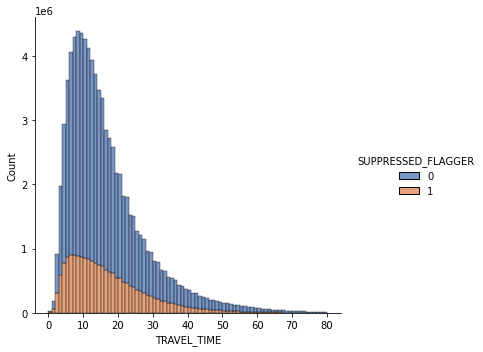

In [27]:
sns.displot(final, stat = 'count', multiple = 'stack', x = 'TRAVEL_TIME',kde=False, bins = 80,
             palette = 'deep', hue = 'SUPPRESSED_FLAGGER', element = 'bars',legend = True)

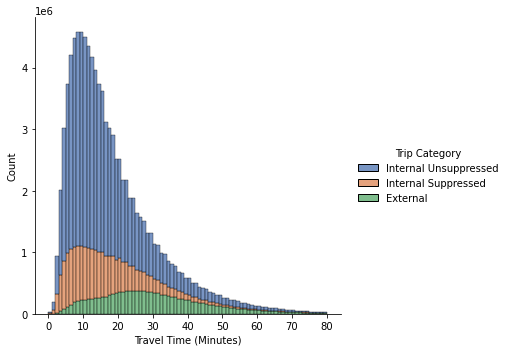

In [96]:
sns.displot(final, stat = 'count', multiple = 'stack', x = 'Travel Time (Minutes)',kde=False, bins = 80,
             palette = 'deep', hue = 'Trip Category', element = 'bars',legend = True)

In [90]:
final.TRAVEL_TIME.value_counts()

15.000000    194008
17.000000    168547
11.000000    156586
10.000000    156016
12.000000    153672
              ...  
0.700000        272
0.566667        271
0.633333        259
0.583333        257
0.016667        185
Name: TRAVEL_TIME, Length: 3764, dtype: int64

In [53]:
final.FARE.value_counts()

5.0     21489113
7.5     18930132
10.0    12928341
12.5     7961829
2.5      5593472
15.0     4754741
17.5     2943769
20.0     2114741
22.5     1759817
25.0     1429325
27.5     1054707
0.0       892405
30.0      735754
32.5      503842
35.0      344801
37.5      231648
40.0      151817
42.5      110111
45.0       89243
47.5       71753
50.0       59828
Name: FARE, dtype: int64

In [104]:
final = final[final['Fare (Dollars)'] <= 50]

In [102]:
len(final['Fare'])

97671415

In [103]:
len(final[final['Fare']<= 50])

97018368

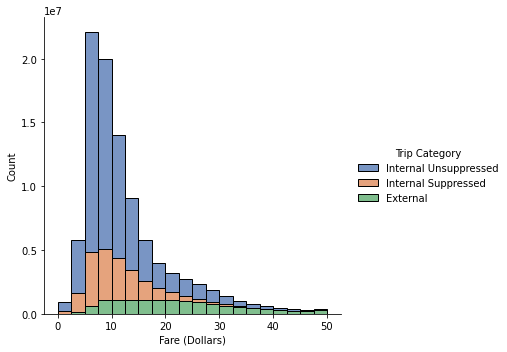

In [105]:
sns.displot(final, stat = 'count', multiple = 'stack', x = 'Fare (Dollars)',kind = 'hist',bins = 20,
             palette = 'deep', hue = 'Trip Category', element = 'bars',legend = True)


In [107]:
final = final[final['Trip Length (Miles)'] <= 40]

In [110]:
df4.TRAVEL_TIME.mean()

16.7762707692901

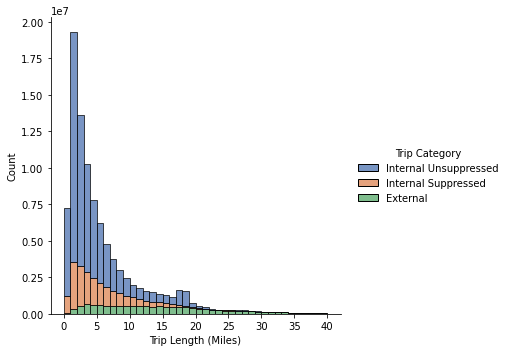

In [108]:
sns.displot(final, stat = 'count', multiple = 'stack', x = 'Trip Length (Miles)',kde=False, bins = 40,
             palette = 'deep', hue = 'Trip Category', element = 'bars',legend = True)

In [ ]:
final.TRIP_MILES.value_counts()

# External vs Internal Visualizations

In [5]:
store = pd.HDFStore('D:/TNC-Demand-Model/Inputs/Chicago Ride-Hailing/Chicago_TNC_Trips_20.H5')

The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.


In [6]:
tods = [1,2,3,4,5]

In [7]:
df2 = pd.DataFrame()
for tod in tods:
    print('Working on TOD ' + str(tod))
    df = store.select(key = 'Weekday_' + str(tod), columns = ['Pickup Census Tract','Dropoff Census Tract','MONTH','YEAR','Pickup Community Area','Dropoff Community Area','Trip Seconds','Trip Miles','Fare'])
    df2 = df2.append(df)

In [ ]:
store.close()

In [8]:
df3 = df2[(~np.isnan(df2['Pickup Census Tract']))&(~np.isnan(df2['Dropoff Census Tract']))]

In [9]:
df_external = df2[(np.isnan(df2['Pickup Community Area']))|(np.isnan(df2['Dropoff Community Area']))]

In [10]:
df_internal = df2[(~np.isnan(df2['Pickup Community Area']))&(~np.isnan(df2['Dropoff Community Area']))]

In [11]:
len(df_external)

13470786

In [12]:
len(df_internal)

84703806

In [13]:
len(df2)

98174592

In [14]:
len(df3)

65208585

In [15]:
len(df2)

98174592

In [16]:
df_external_suppressed = df_external[(np.isnan(df_external['Pickup Census Tract']))&(np.isnan(df_external['Dropoff Census Tract']))]

In [17]:
len(df_external_suppressed)

4831124

In [61]:
df_external['EXTERNAL_TRIPS'] = 1
#df_external['DAY'] = df_external['Trip Start Timestamp'].dt.day
#df_external['MINUTE'] = df_external['Trip Start Timestamp'].dt.minute


In [19]:
df_external_pickup = df_external.groupby(by = ['MONTH','YEAR','DAY','Pickup Community Area'],as_index = False).sum()

KeyError: 'DAY'

In [67]:
#df_external_pickup_avg = df_external_pickup.groupby(by = ['MONTH','YEAR','Pickup Community Area'],as_index = False).mean()
df_external_pickup_sum = df_external.groupby(by = ['MONTH','YEAR','Pickup Community Area'],as_index = False).sum()

In [65]:
#df_external_dropoff = df_external.groupby(by = ['MONTH','YEAR','DAY','Dropoff Community Area'],as_index = False).sum()
#df_external_dropoff_avg = df_external_dropoff.groupby(by = ['MONTH','YEAR','Dropoff Community Area'],as_index = False).mean()
df_external_dropoff_sum = df_external.groupby(by = ['MONTH','YEAR','Dropoff Community Area'],as_index = False).sum()

In [64]:
df= pd.DataFrame()

In [66]:
df_internal['INTERNAL_TRIPS'] = 1
#df_internal['DAY'] = df_internal['Trip Start Timestamp'].dt.day
#df_internal['MINUTE'] = df_internal['Trip Start Timestamp'].dt.minute


In [68]:
#df_internal_pickup = df_internal.groupby(by = ['MONTH','YEAR','DAY','Pickup Community Area'],as_index = False).sum()
#df_internal_pickup_avg = df_internal_pickup.groupby(by = ['MONTH','YEAR','Pickup Community Area'],as_index = False).mean()
df_internal_pickup_sum = df_internal.groupby(by = ['MONTH','YEAR','Pickup Community Area'],as_index = False).sum()

In [69]:
#df_internal_dropoff = df_internal.groupby(by = ['MONTH','YEAR','DAY','Dropoff Community Area'],as_index = False).sum()
#df_internal_dropoff_avg = df_internal_dropoff.groupby(by = ['MONTH','YEAR','Dropoff Community Area'],as_index = False).mean()
df_internal_dropoff_sum = df_internal.groupby(by = ['MONTH','YEAR','Dropoff Community Area'],as_index = False).sum()

In [70]:
join_pickup = df_internal_pickup_sum.merge(df_external_pickup_sum, on = ['MONTH','YEAR','Pickup Community Area'])
join_dropoff = df_internal_dropoff_sum.merge(df_external_dropoff_sum, on = ['MONTH','YEAR','Dropoff Community Area'])


In [71]:
join_pickup['Share of Trips External'] = join_pickup['EXTERNAL_TRIPS']/(join_pickup['INTERNAL_TRIPS'] + join_pickup['EXTERNAL_TRIPS'])
join_dropoff['Share of Trips External'] = join_dropoff['EXTERNAL_TRIPS']/(join_dropoff['INTERNAL_TRIPS'] + join_dropoff['EXTERNAL_TRIPS'])


In [72]:

m = folium.Map([41.8781, -87.6298],  tiles= None, zoom_start=11)

# Add the color for the chloropleth:
folium.Choropleth(
 geo_data=com_area,
 name= "Share of Pickups Being Suppressed",
 data=join_pickup,
 columns = ['Pickup Community Area', 'Share of Trips External'],
 key_on='feature.properties.area_num_1',
 fill_color='BuGn',
 fill_opacity=0.6,
 line_opacity=0.2,
 bins = 4,
 legend_name='Share of Pickups With External Dropoff',
 highlight = True
).add_to(m)



#feature_group = folium.FeatureGroup(name='Census Tract Centroids', show = False)


#for tract2 in centroids.GEOID:
#    row = centroids[centroids['GEOID'] == tract2]
#    folium.CircleMarker([row['Y'], row['X']], popup = str(int(row['GEOID'].values[0])), radius = 1, fill = True, fill_color = 'grey', color = 'grey').add_to(feature_group)

#m.add_child(feature_group)


folium.LayerControl().add_to(m)

m.save('D:/TNC-Demand-Model/Data Exploration/Share_of_Pickups_External.html')


In [73]:

m = folium.Map([41.8781, -87.6298] , zoom_start=11)

# Add the color for the chloropleth:
folium.Choropleth(
 geo_data=com_area,
 name= "Total External Trips",
 data=join_pickup,
 columns = ['Pickup Community Area', 'EXTERNAL_TRIPS'],
 key_on='feature.properties.area_num_1',
 fill_color='BuGn',
 fill_opacity=0.6,
 line_opacity=0.2,
 legend_name='External Pickups',
 highlight = True
).add_to(m)



#feature_group = folium.FeatureGroup(name='Census Tract Centroids', show = False)


#for tract2 in centroids.GEOID:
#    row = centroids[centroids['GEOID'] == tract2]
#    folium.CircleMarker([row['Y'], row['X']], popup = str(int(row['GEOID'].values[0])), radius = 1, fill = True, fill_color = 'grey', color = 'grey').add_to(feature_group)

#m.add_child(feature_group)


folium.LayerControl().add_to(m)

m.save('D:/TNC-Demand-Model/Data Exploration/External_Trips.html')


In [74]:
rh_pop = join_pickup[['EXTERNAL_TRIPS','Pickup Community Area']].merge(acs_com, how = 'inner', left_on = 'Pickup Community Area', right_on = 'area_num_1')

In [75]:
rh_pop['PICKUP_PER_PERSON'] = rh_pop['EXTERNAL_TRIPS']/rh_pop['TOTAL_POP']

In [76]:

m = folium.Map([41.8781, -87.6298],  tiles= None, zoom_start=11)

# Add the color for the chloropleth:
folium.Choropleth(
 geo_data=com_area,
 name= "Total External Trips",
 data=rh_pop,
 columns = ['Pickup Community Area', 'PICKUP_PER_PERSON'],
 key_on='feature.properties.area_num_1',
 fill_color='BuGn',
 bins = 4,
 fill_opacity=0.6,
 line_opacity=0.2,
 legend_name='External Pickups Per Capita',
 highlight = True
).add_to(m)



#feature_group = folium.FeatureGroup(name='Census Tract Centroids', show = False)


#for tract2 in centroids.GEOID:
#    row = centroids[centroids['GEOID'] == tract2]
#    folium.CircleMarker([row['Y'], row['X']], popup = str(int(row['GEOID'].values[0])), radius = 1, fill = True, fill_color = 'grey', color = 'grey').add_to(feature_group)

#m.add_child(feature_group)


folium.LayerControl().add_to(m)

m.save('D:/TNC-Demand-Model/Data Exploration/External_Trips_Per_Capita.html')


In [77]:
df_external['TRAVEL_TIME'] = df_external['Trip Seconds']/60
df_internal['TRAVEL_TIME'] = df_internal['Trip Seconds']/60

df_internal['SPEED'] = df_internal['Trip Miles']/(df_internal['TRAVEL_TIME']/60)
df_external['SPEED'] = df_external['Trip Miles']/(df_external['TRAVEL_TIME']/60)

In [78]:
df_external = df_external[df_external['TRAVEL_TIME'] <= 80]
df_internal = df_internal[df_internal['TRAVEL_TIME'] <= 80]

In [79]:
df_external['EXTERNAL_FLAGGER'] = 1
df_internal['EXTERNAL_FLAGGER'] = 0


In [80]:
final = df_external.append(df_internal)

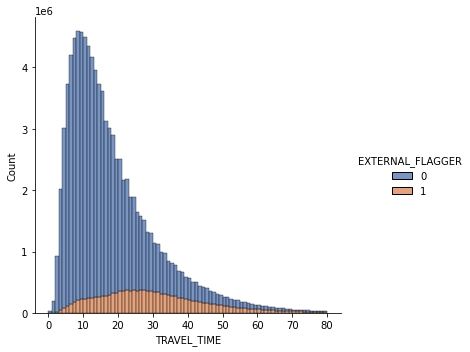

In [51]:
sns.displot(final, stat = 'count', multiple = 'stack', x = 'TRAVEL_TIME',kde=False, bins = 80,
             palette = 'deep', hue = 'EXTERNAL_FLAGGER', element = 'bars',legend = True)

In [52]:
final = final[final['Fare'] <= 50]

In [53]:
final['FARE'] = final['Fare']

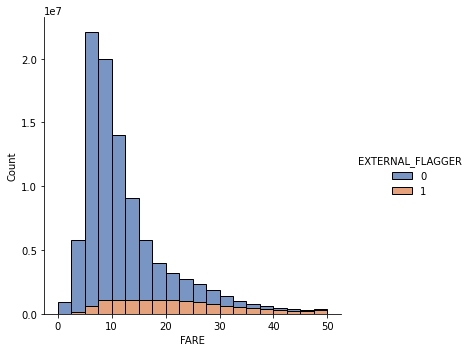

In [54]:
sns.displot(final, stat = 'count', multiple = 'stack', x = 'FARE',kind = 'hist',bins = 20,
             palette = 'deep', hue = 'EXTERNAL_FLAGGER')

In [57]:
df3 = pd.DataFrame()

In [81]:
final = final[final['Trip Miles'] <= 40]

In [82]:
final['TRIP_MILES'] = final['Trip Miles']

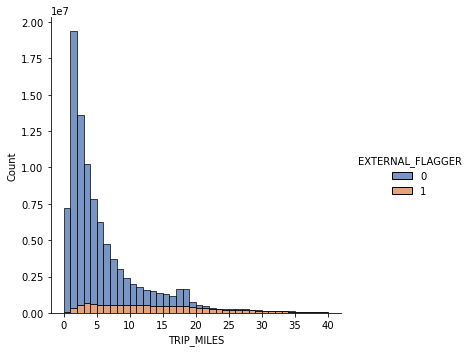

In [83]:
sns.displot(final, stat = 'count', multiple = 'stack', x = 'TRIP_MILES',kde=False, bins = 40,
             palette = 'deep', hue = 'EXTERNAL_FLAGGER', element = 'bars',legend = True)

In [ ]:
df_external['HOUR'] = df_external['Trip End Timestamp'].dt.hour

In [ ]:
df_external[['HOUR','EXTERNAL_TRIPS']].groupby(by = 'HOUR').sum()

In [ ]:
df_unsup['HOUR'] = df_unsup['Trip End Timestamp'].dt.hour

In [ ]:
df4['HOUR'] = df4['Trip End Timestamp'].dt.hour

In [ ]:
df_unsup[['HOUR','UNSUPPRESSED_TRIPS']].groupby(by = 'HOUR').sum()

In [ ]:
df4[['HOUR','SUPPRESSED_TRIPS']].groupby(by = 'HOUR').sum()